In [8]:
# =======================
# 📦 IMPORTACIONES
# =======================

# Built-in
import os
import sys
import re
import time
import json
import random
import warnings
from typing import List, Tuple, Dict
import operator
import re
from pathlib import Path
import numpy as np
import pandas as pd


# NumPy, Pandas, Matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    log_loss, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, pairwise_distances
)
from sklearn.exceptions import NotFittedError
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix


# Flower
from flwr.client import ClientApp, NumPyClient
from flwr.common import (
    Context, NDArrays, Metrics, Scalar,
    ndarrays_to_parameters, parameters_to_ndarrays
)
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# LORE
from lore_sa.dataset import TabularDataset
from lore_sa.bbox import sklearn_classifier_bbox
from lore_sa.encoder_decoder import ColumnTransformerEnc
from lore_sa.lore import TabularGeneticGeneratorLore
from lore_sa.surrogate.decision_tree import SuperTree
from lore_sa.rule import Expression, Rule

from lore_sa.client_utils import ClientUtilsMixin  

# Otros
from pathlib import Path
from filelock import FileLock  # pip install filelock
import pandas as pd, os
from graphviz import Digraph
from datetime import datetime

In [9]:
# =======================
# ⚙️ VARIABLES GLOBALES
# =======================
UNIQUE_LABELS = []
FEATURES = []
NUM_SERVER_ROUNDS = 2
NUM_CLIENTS = 4
SEED = 42
MIN_AVAILABLE_CLIENTS = NUM_CLIENTS
fds = None  # Cache del FederatedDataset
CAT_ENCODINGS = {}
USING_DATASET = None


# ==============================================
# 🧹 Borrar TODOS los CSV individuales de clientes
# ==============================================

csv_dir = Path("results")
all_csvs = list(csv_dir.glob("*.csv"))

# Solo borrar si hay alguno
if all_csvs:
    for f in all_csvs:
        try:
            f.unlink()
        except Exception:
            pass  # Ignora errores




# =======================
# 🔧 UTILIDADES MODELO
# =======================

def get_model_parameters(tree_model, nn_model):
    tree_params = [
        int(tree_model.get_params()["max_depth"] or -1),
        int(tree_model.get_params()["min_samples_split"]),
        int(tree_model.get_params()["min_samples_leaf"]),
    ]
    nn_weights = [v.cpu().detach().numpy() for v in nn_model.state_dict().values()]
    return {
        "tree": tree_params,
        "nn": nn_weights,
    }


def set_model_params(tree_model, nn_model, params):
    tree_params = params["tree"]
    nn_weights = params["nn"]

    # Solo si tree_model no es None y tiene set_params
    if tree_model is not None and hasattr(tree_model, "set_params"):
        max_depth = tree_params[0] if tree_params[0] > 0 else None
        tree_model.set_params(
            max_depth=max_depth,
            min_samples_split=tree_params[1],
            min_samples_leaf=tree_params[2],
        )

    # Actualizar pesos de la red neuronal
    state_dict = nn_model.state_dict()
    for (key, _), val in zip(state_dict.items(), nn_weights):
        state_dict[key] = torch.tensor(val)
    nn_model.load_state_dict(state_dict)


# =======================
# 📥 CARGAR DATOS
# =======================

def get_global_onehot_info(flower_dataset_name, class_col):
    partitioner = IidPartitioner(num_partitions=1)
    fds_tmp = FederatedDataset(dataset=flower_dataset_name, partitioners={"train": partitioner})
    df = fds_tmp.load_partition(0, "train").with_format("pandas")[:]

    # Preprocesado estándar
    if "adult_small" in flower_dataset_name.lower():
        drop_cols = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
        df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    elif "churn" in flower_dataset_name.lower():
        drop_cols = ['customerID', 'TotalCharges']
        df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
        df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
        df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
        df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'}).astype(str)
        df.dropna(subset=['MonthlyCharges', 'tenure'], inplace=True)
    
    elif "breastcancer" in flower_dataset_name.lower():
        # Preprocesado específico para el dataset de cáncer de mama
        df.drop(columns=['id'], inplace=True, errors='ignore')



    for col in df.select_dtypes(include=["object"]).columns:
        if df[col].nunique() < 50:
            df[col] = df[col].astype("category")

    cat_features = [col for col in df.select_dtypes(include="category").columns if col != class_col]
    num_features = [col for col in df.columns if df[col].dtype.kind in "fi" and col != class_col]

    ohe = OneHotEncoder(handle_unknown="ignore")
    ohe.fit(df[cat_features])
    categories_global = ohe.categories_
    onehot_columns = ohe.get_feature_names_out(cat_features).tolist()
    return cat_features, num_features, categories_global, onehot_columns



def load_data_general(flower_dataset_name: str, class_col: str, partition_id: int, num_partitions: int):
    global fds, UNIQUE_LABELS, FEATURES

    # Saca info global siempre al principio
    cat_features, num_features, categories_global, onehot_columns = get_global_onehot_info(flower_dataset_name, class_col)

    if fds is None:
        partitioner = IidPartitioner(num_partitions=num_partitions)
        fds = FederatedDataset(dataset=flower_dataset_name, partitioners={"train": partitioner})

    dataset = fds.load_partition(partition_id, "train").with_format("pandas")[:]

    # Preprocesado específico por dataset
    if "adult" in flower_dataset_name.lower():
        drop_cols = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
        dataset.drop(columns=[col for col in drop_cols if col in dataset.columns], inplace=True)

    elif "churn" in flower_dataset_name.lower():
        drop_cols = ['customerID', 'TotalCharges']
        dataset.drop(columns=[col for col in drop_cols if col in dataset.columns], inplace=True)
        dataset['MonthlyCharges'] = pd.to_numeric(dataset['MonthlyCharges'], errors='coerce')
        dataset['tenure'] = pd.to_numeric(dataset['tenure'], errors='coerce')
        dataset['SeniorCitizen'] = dataset['SeniorCitizen'].map({0: 'No', 1: 'Yes'}).astype(str)

        dataset.dropna(subset=['MonthlyCharges', 'tenure'], inplace=True)

    elif "breastcancer" in flower_dataset_name.lower():
        # Preprocesado específico para el dataset de cáncer de mama
        dataset.drop(columns=['id'], inplace=True, errors='ignore')

    for col in dataset.select_dtypes(include=["object"]).columns:
        if dataset[col].nunique() < 50:
            dataset[col] = dataset[col].astype("category")

    class_original = dataset[class_col].copy()
    tabular_dataset = TabularDataset(dataset.copy(), class_name=class_col)
    descriptor = tabular_dataset.descriptor

    for col, info in descriptor["categorical"].items():
        if "distinct_values" not in info or not info["distinct_values"]:
            info["distinct_values"] = list(dataset[col].dropna().unique())

    label_encoder = LabelEncoder()
    label_encoder.fit(dataset[class_col])
    if not UNIQUE_LABELS:
        UNIQUE_LABELS[:] = label_encoder.classes_.tolist()
    label_encoder.classes_ = np.array(UNIQUE_LABELS)
    dataset[class_col] = label_encoder.transform(dataset[class_col])
    dataset.rename(columns={class_col: "class"}, inplace=True)
    y = dataset["class"].reset_index(drop=True).to_numpy()

    numeric_features = list(descriptor["numeric"].keys())
    categorical_features = list(descriptor["categorical"].keys())
    FEATURES[:] = numeric_features + categorical_features

    numeric_indices = list(range(len(numeric_features)))
    categorical_indices = list(range(len(numeric_features), len(FEATURES)))

    X_array = dataset[FEATURES].to_numpy()

    preprocessor = ColumnTransformer([
        ("num", "passthrough", numeric_indices),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore", categories=categories_global), categorical_indices)
    ])
    X_encoded = preprocessor.fit_transform(X_array)

    # Reconstrucción del DataFrame
    num_out = X_encoded[:, :len(numeric_features)]
    cat_out = X_encoded[:, len(numeric_features):]
    if categorical_features:
        cat_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
    else:
        cat_names = []

    num_names = numeric_features

    X_df = pd.DataFrame(num_out, columns=num_names)
    if len(cat_names) > 0:
        X_cat_df = pd.DataFrame(cat_out, columns=cat_names)
        X_full = pd.concat([X_df.reset_index(drop=True), X_cat_df.reset_index(drop=True)], axis=1)
        for col in onehot_columns:
            if col not in X_cat_df.columns:
                X_full[col] = 0
    else:
        X_full = X_df

    # Rellenar columnas onehot que falten y ordenar
    final_columns = num_names + list(cat_names)
    X_full = X_full[final_columns]
    FEATURES[:] = final_columns

    split_idx = int(0.7 * len(X_full))

        # --- ¡Construye el descriptor global! ---
    descriptor_global = descriptor.copy()
    for i, col in enumerate(cat_features):
        if col in descriptor_global["categorical"]:
            descriptor_global["categorical"][col]["distinct_values"] = list(categories_global[i])

    encoder = ColumnTransformerEnc(descriptor_global)

    return (
        X_full.iloc[:split_idx].to_numpy(), y[:split_idx],
        X_full.iloc[split_idx:].to_numpy(), y[split_idx:],
        tabular_dataset, final_columns, label_encoder,
        preprocessor.named_transformers_["num"], numeric_features, encoder, preprocessor
    )

# =======================


# Los resultados de las métricas no son muy buenos aqui
# DATASET_NAME = "pablopalacios23/adult"
# CLASS_COLUMN = "class"


# DATASET_NAME = "pablopalacios23/Iris"
# CLASS_COLUMN = "target"


# DATASET_NAME = "pablopalacios23/churn"
# CLASS_COLUMN = "Churn" 



DATASET_NAME = "pablopalacios23/HeartDisease"
CLASS_COLUMN = "HeartDisease" 



# DATASET_NAME = "pablopalacios23/breastcancer"
# CLASS_COLUMN = "diagnosis" 



# DATASET_NAME = "pablopalacios23/Diabetes"
# CLASS_COLUMN = "Outcome" 


 
# =======================


# load_data_general(DATASET_NAME, CLASS_COLUMN, partition_id=0, num_partitions=NUM_CLIENTS)

### HOLDOUT DEL SERVIDOR

In [10]:
X_train, y_train, X_test, y_test, dataset, feature_names, label_encoder, scaler, numeric_features, encoder, preprocessor = load_data_general(
    DATASET_NAME, CLASS_COLUMN, partition_id=0, num_partitions=NUM_CLIENTS
)

# Mostrar 5 primeros valores
print("\n📦 X_train (primeras filas):")
print(pd.DataFrame(X_train))

print("\n🎯 y_train (primeros valores):")
print(y_train)

print("\n📦 X_test (primeras filas):")
print(pd.DataFrame(X_test))

print("\n🎯 y_test (primeros valores):")
print(y_test)

print(feature_names)



📦 X_train (primeras filas):
   0    1    2  3    4    5    6    7    8    9    10   11   12   13   14  \
0  44  118  242  0  149  0.3  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
1  46  140  311  0  120  1.8  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2  42  115  211  0  137  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   
3  74  138    0  0  116  0.2  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
4  45  130  236  0  144  0.1  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
5  58  130  230  0  150  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
6  72  160    0  0  114  1.6  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
7  55  172  260  0   73  2.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
8  63  133    0  0  120  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
9  74  145    0  1  123  1.3  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   

    15   16   17   18   19  
0  1.0  0.0  0.0  1.0  0.0  
1  0.0  1.0  0.0  1.0  0.0  
2  1.0  0.0  0.0  0.0  1.0  
3  1.0 

# Cliente

In [11]:
# ==========================
# 🌼 CLIENTE FLOWER
# ==========================
import operator
import warnings
import os
import json
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    log_loss, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.exceptions import NotFittedError

import torch
import torch.nn as nn
import torch.nn.functional as F

from flwr.client import NumPyClient
from flwr.common import Context
from flwr.common import parameters_to_ndarrays

from lore_sa.dataset import TabularDataset
from lore_sa.bbox import sklearn_classifier_bbox
from lore_sa.lore import TabularGeneticGeneratorLore
from lore_sa.rule import Expression, Rule
from lore_sa.surrogate.decision_tree import SuperTree
from lore_sa.encoder_decoder import ColumnTransformerEnc

from sklearn.metrics import pairwise_distances


class TorchNNWrapper:
    def __init__(self, model, num_idx, mean, scale):
        self.model = model
        self.model.eval()
        self.num_idx = np.asarray(num_idx, dtype=int)
        self.mean = np.asarray(mean, dtype=np.float32)
        self.scale = np.asarray(scale, dtype=np.float32)
        self.scale_safe = np.where(self.scale == 0, 1.0, self.scale)

    def _scale_internally(self, X):
        X = np.asarray(X, dtype=np.float32)
        Xs = X.copy()
        # soporta [n, d] o [d]
        if Xs.ndim == 1:
            Xs = Xs[None, :]
        Xs[:, self.num_idx] = (Xs[:, self.num_idx] - self.mean) / self.scale_safe
        return Xs

    def predict(self, X):
        Xs = self._scale_internally(X)
        with torch.no_grad():
            X_tensor = torch.tensor(Xs, dtype=torch.float32)
            logits = self.model(X_tensor)
            return logits.argmax(dim=1).cpu().numpy()

    def predict_proba(self, X):
        Xs = self._scale_internally(X)
        with torch.no_grad():
            X_tensor = torch.tensor(Xs, dtype=torch.float32)
            logits = self.model(X_tensor)
            probs = F.softmax(logits, dim=1)
            return probs.cpu().numpy()

class Net(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(Net, self).__init__()
        hidden_dim = max(8, input_dim * 2)  # algo proporcional

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
        

class FlowerClient(NumPyClient, ClientUtilsMixin):
    def __init__(self, tree_model, nn_model, X_train, y_train, X_test, y_test, X_train_nn, X_test_nn, scaler_nn_mean, scaler_nn_scale, num_idx, dataset, client_id, feature_names, label_encoder, scaler, numeric_features, encoder, preprocessor):
        self.tree_model = tree_model
        self.nn_model = nn_model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_nn = X_train_nn
        self.X_test_nn  = X_test_nn
        self.scaler_nn_mean = np.asarray(scaler_nn_mean, dtype=np.float32)
        self.scaler_nn_scale = np.where(np.asarray(scaler_nn_scale, np.float32)==0, 1.0, np.asarray(scaler_nn_scale, np.float32))
        self.num_idx = np.asarray(num_idx, dtype=int)
        self.dataset = dataset
        self.client_id = client_id
        self.feature_names = feature_names
        self.label_encoder = label_encoder
        self.scaler = scaler
        self.numeric_features = numeric_features
        self.encoder = encoder
        self.unique_labels = label_encoder.classes_.tolist()
        self.y_train_nn = y_train.astype(np.int64)
        self.y_test_nn = y_test.astype(np.int64)
        self.received_supertree = None
        self.preprocessor = preprocessor

    def _train_nn(self, epochs=10, lr=0.01):
        self.nn_model.train()
        optimizer = torch.optim.Adam(self.nn_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        X_tensor = torch.tensor(self.X_train_nn, dtype=torch.float32)
        y_tensor = torch.tensor(self.y_train_nn, dtype=torch.long)

        for _ in range(epochs):
            optimizer.zero_grad()
            outputs = self.nn_model(X_tensor)
            loss = loss_fn(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        print(f"[CLIENTE {self.client_id}] ✅ Red neuronal entrenada")


    def fit(self, parameters, config):
        set_model_params(self.tree_model, self.nn_model, {"tree": [
            self.tree_model.get_params()["max_depth"],
            self.tree_model.get_params()["min_samples_split"],
            self.tree_model.get_params()["min_samples_leaf"],
        ], "nn": parameters})
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            self.tree_model.fit(self.X_train, self.y_train)

            self._train_nn()


        nn_weights = get_model_parameters(self.tree_model, self.nn_model)["nn"]
        return nn_weights, len(self.X_train), {}
    


    def evaluate(self, parameters, config):


        set_model_params(self.tree_model, self.nn_model, {"tree": [
            self.tree_model.get_params()["max_depth"],
            self.tree_model.get_params()["min_samples_split"],
            self.tree_model.get_params()["min_samples_leaf"],
        ], "nn": parameters})

        if "supertree" in config:
            try:
                print("Recibiendo supertree....")
                supertree_dict = json.loads(config["supertree"])
                
                # print("supertree_dict")
                # print("supertree_dict:", supertree_dict)
                # print("type:", type(supertree_dict))
                # print("dir(supertree_dict):", dir(supertree_dict))
                # print("\n")

                self.received_supertree = SuperTree.convert_SuperNode_to_Node(SuperTree.SuperNode.from_dict(supertree_dict))
                self.global_mapping = json.loads(config["global_mapping"])
                self.feature_names = json.loads(config["feature_names"])

            except Exception as e:
                print(f"[CLIENTE {self.client_id}] ❌ Error al recibir SuperTree: {e}")

        try:
            _ = self.tree_model.predict(self.X_test)
        except NotFittedError:
            self.tree_model.fit(self.X_train, self.y_train)

        round_number = config.get("server_round", 1)
        
        supertree = SuperTree()
        root_node = supertree.rec_buildTree(self.tree_model, list(range(self.X_train.shape[1])), len(self.unique_labels))
        
        root_node = supertree.prune_redundant_leaves_local(root_node)

        # print(f"[CLIENTE {self.client_id}]")
        # print(export_text(self.tree_model, feature_names=FEATURES))
        # print("root_node:", root_node)
        # print("type:", type(root_node))
        # print(dir(root_node))
        # print("\n")
        # print("FEATURES:", FEATURES)

        
        self._save_local_tree(root_node, round_number, FEATURES, self.numeric_features,scaler=None, unique_labels=UNIQUE_LABELS, encoder=self.encoder)
        tree_json = json.dumps([root_node.to_dict()])

        if self.received_supertree is not None and config.get("server_round", 0) == NUM_SERVER_ROUNDS:
            self._explain_local_and_global(config)


        return 0.0, len(self.X_test), {
            f"tree_ensemble_{self.client_id}": tree_json,
            f"encoded_feature_names_{self.client_id}": json.dumps(FEATURES),
            f"numeric_features_{self.client_id}": json.dumps(self.numeric_features),
            f"unique_labels_{self.client_id}": json.dumps(self.unique_labels),
            f"distinct_values_{self.client_id}": json.dumps(self.encoder.dataset_descriptor["categorical"])
        }
    
    def _explain_local_and_global(self, config):
        from sklearn.metrics import accuracy_score
        import numpy as np
        
    
        num_row = 0

        # Wrapper que escala SOLO para la NN (espacio NN)
        nn_wrapper = TorchNNWrapper(
            self.nn_model,
            num_idx=self.num_idx,
            mean=self.scaler_nn_mean,
            scale=self.scaler_nn_scale,
        )

        # 1. Visualizar instancia escalada y decodificada usando el encoder/preprocessor ORIGINAL
        
        decoded = self.decode_onehot_instance(
            self.X_test[num_row],
            self.numeric_features,
            self.encoder,
            None,                 # <-- sin scaler (en crudo)
            self.feature_names
        )

        # print("self.X_test[num_row]:", self.X_test[num_row])
        # print(f"\n[CLIENTE {self.client_id}] 🧪 Instancia a explicar (decodificada):")
        # print(decoded)
        # print(f"[CLIENTE {self.client_id}] 🧪 Clase real: {self.label_encoder.inverse_transform([self.y_test_nn[num_row]])[0]}")

        # Asegúrate de que X_test[num_row] es un numpy array del shape correcto (1, n_features)
        row = np.asarray(self.X_test[num_row], dtype=np.float32)
        probs = nn_wrapper.predict_proba(row[None, :])
        pred_class_idx = int(probs.argmax(axis=1)[0])

        # Si tienes un label_encoder:
        pred_class = self.label_encoder.inverse_transform([pred_class_idx])[0]

        # 2. Construir DataFrame para LORE (si es necesario, solo para TabularDataset)

        # Ahora crea el TabularDataset legible
        local_df = pd.DataFrame(self.X_train, columns=self.feature_names).astype(np.float32)
        local_df["class"] = self.label_encoder.inverse_transform(self.y_train_nn)
        
        local_tabular_dataset = TabularDataset(local_df, class_name="class")    

        # Explicabilidad local y la vecindad es generada del train (local_tabular_dataset)
        bbox = sklearn_classifier_bbox.sklearnBBox(nn_wrapper)
        lore_vecindad = TabularGeneticGeneratorLore(bbox, local_tabular_dataset)
        
        # Explicación LORE
        x_instance = pd.Series(self.X_test[num_row], index=self.feature_names)

        round_number = config.get("server_round", 1)
        
        explanation = lore_vecindad.explain_instance(x_instance, merge=True, num_classes=len(UNIQUE_LABELS), feature_names= self.feature_names, categorical_features=list(self.global_mapping.keys()), global_mapping=self.global_mapping, UNIQUE_LABELS=UNIQUE_LABELS,
                                                     client_id=self.client_id, round_number=round_number)

        lore_tree = explanation["merged_tree"]
        
        # self.print_tree_readable(node=lore_tree.root,feature_names=self.feature_names,class_names=UNIQUE_LABELS,numeric_features=self.numeric_features,encoder=self.encoder)
        # print('\n')
        
        self.save_lore_tree_image(lore_tree.root,round_number,self.feature_names,self.numeric_features,UNIQUE_LABELS,self.encoder,folder="LoreTree")
        # Alinear el árbol local de LORE al espacio global para que no haya probelemas al unirlo

        merged_tree = SuperTree()
        merged_tree.mergeDecisionTrees(
            roots=[lore_tree.root, self.received_supertree],
            num_classes=len(self.unique_labels),
            feature_names=self.feature_names,
            categorical_features=list(self.global_mapping.keys()), 
            global_mapping=self.global_mapping
        )

        merged_tree.prune_redundant_leaves_full()

        merged_tree.merge_equal_class_leaves()

        self.save_mergedTree_plot(root_node=merged_tree.root,round_number=round_number,feature_names=self.feature_names,class_names=self.unique_labels,numeric_features=self.numeric_features,scaler=None, global_mapping=self.global_mapping,folder="MergedTree")

        tree_str = self.tree_to_str(merged_tree.root,self.feature_names,numeric_features=self.numeric_features,scaler=None, global_mapping=self.global_mapping,unique_labels=self.unique_labels)
        
        lore_tree_str = self.tree_to_str(lore_tree.root, self.feature_names, numeric_features=self.numeric_features,scaler=None,global_mapping=self.global_mapping,unique_labels=self.unique_labels)

        supertree_str = self.tree_to_str(self.received_supertree, self.feature_names, numeric_features=self.numeric_features,scaler=None,global_mapping=self.global_mapping,unique_labels=self.unique_labels)
           
        rules = self.extract_rules_from_str(tree_str, target_class_label=pred_class)
        rules_lore = self.extract_rules_from_str(lore_tree_str, target_class_label=pred_class)
        rules_supertree = self.extract_rules_from_str(supertree_str, target_class_label=pred_class)


    
        def cumple_regla(instancia, regla):
            for cond in regla:
                if "∧" in cond:
                    # Maneja condiciones tipo intervalo: 'age > 44.33 ∧ ≤ 48.50'
                    import re
                    # Busca: variable, operador1, valor1, operador2, valor2
                    m = re.match(r'(.+?)([><]=?|≤|≥)\s*([-\d\.]+)\s*∧\s*([><]=?|≤|≥)\s*([-\d\.]+)', cond)
                    if m:
                        var = m.group(1).strip()
                        op1, val1 = m.group(2), float(m.group(3))
                        op2, val2 = m.group(4), float(m.group(5))
                        v = instancia[var]
                        # Evalúa las dos condiciones del intervalo
                        if not (
                            eval(f"v {op1.replace('≤','<=').replace('≥','>=')} {val1}") and
                            eval(f"v {op2.replace('≤','<=').replace('≥','>=')} {val2}")
                        ):
                            return False
                        continue  # sigue al siguiente cond
                # ... resto de tu código tal cual ...
                if "≤" in cond:
                    var, val = cond.split("≤")
                    var = var.strip()
                    val = float(val.strip())
                    if instancia[var] > val:
                        return False
                elif ">=" in cond or "≥" in cond:
                    var, val = cond.replace("≥", ">=").split(">=")
                    var = var.strip()
                    val = float(val.strip())
                    if instancia[var] < val:
                        return False
                elif ">" in cond:
                    var, val = cond.split(">")
                    var = var.strip()
                    val = float(val.strip())
                    if instancia[var] <= val:
                        return False
                elif "<" in cond:
                    var, val = cond.split("<")
                    var = var.strip()
                    val = float(val.strip())
                    if instancia[var] >= val:
                        return False
                elif "≠" in cond:
                    var, val = cond.split("≠")
                    var = var.strip()
                    val = val.strip().replace('"', "")
                    if instancia[var] == val:
                        return False
                elif "=" in cond:
                    var, val = cond.split("=")
                    var = var.strip()
                    val = val.strip().replace('"', "")
                    if instancia[var] != val:
                        return False
            return True

        # Buscar la regla factual (la que cubre la instancia)
        regla_factual = None
        for regla in rules:
            if cumple_regla(decoded, regla):
                regla_factual = regla
                break

        # 3) Regla factual de LORE: la que cubre la instancia decodificada 'decoded'
        regla_factual_lore = None
        for r in rules_lore:
            if cumple_regla(decoded, r):
                regla_factual_lore = r
                break

        regla_factual_supertree = None
        for r in rules_supertree:
            if cumple_regla(decoded, r):
                regla_factual_supertree = r
                break


        

        # Extraer 1 contrafactual por cada clase distinta a la predicha
        cf_rules_por_clase = {}
        for clase in self.unique_labels:
            if clase != pred_class:
                rules_clase = self.extract_rules_from_str(tree_str, target_class_label=clase)
                if rules_clase:
                    # Elige la más sencilla (menos condiciones)
                    cf_rules_por_clase[clase] = min(rules_clase, key=len)



        # Extraer 1 contrafactual tipo LORE por cada clase distinta a la predicha
        cf_rules_LORE_por_clase = {}
        for clase in self.unique_labels:
            if clase != pred_class:
                rules_clase = self.extract_rules_from_str(lore_tree_str, target_class_label=clase)
                if rules_clase:
                    # Elige la más sencilla (menos condiciones)
                    cf_rules_LORE_por_clase[clase] = min(rules_clase, key=len)


        cf_rules_Supertree_por_clase = {}
        for clase in self.unique_labels:
            if clase != pred_class:
                rules_clase = self.extract_rules_from_str(supertree_str, target_class_label=clase)
                if rules_clase:
                    # Elige la más sencilla (menos condiciones)
                    cf_rules_Supertree_por_clase[clase] = min(rules_clase, key=len)
        

        

        

        

        # ========================================================================================================================================================================================================
        # 📏 MÉTRICAS DE EXPLICACIÓN tipo LORE 
        # ========================================================================================================================================================================================================

        Z = explanation["neighborhood_Z"] # instancias del vecindario sintético generado alrededor del punto a explicar.
        y_bb = explanation["neighborhood_Yb"] # predicciones del modelo BBOX (red neuronal) sobre Z (el vecindario).

        y_surrogate_preds = explanation["surrogate_preds"]  # predicciones del modelo interpretable (arbol - LORE Tree) sobre Z (el vecindario).

        # Convertir Z en DataFrame legible
        dfZ = pd.DataFrame(Z, columns=self.feature_names)


        # ==============================================================================================
        # Silhouette:  Distancia media entre x y las instancias de su misma clase en el vecindario (Z+)
        # ==============================================================================================

        mask_same_class = (y_bb == pred_class_idx)
        mask_diff_class = (y_bb != pred_class_idx)

        Z_plus = dfZ[mask_same_class]
        Z_minus = dfZ[mask_diff_class]

        x = self.X_test[num_row]

        a = pairwise_distances([x], Z_plus).mean() if len(Z_plus) > 0 else 0.0

        b = pairwise_distances([x], Z_minus).mean() if len(Z_minus) > 0 else 0.0

        silhouette = 0.0
        if (a + b) > 0:
            silhouette = (b - a) / max(a, b)



        # ===========================================================================================================================================================
        # Fidelity: Porcentaje de veces que el modelo interpretable (LORE tree) predice lo mismo que el modelo original (Red neuronal) en el vecindario generado.

        # Un valor alto de fidelity significa que el árbol surrogate está imitando bien a la red neuronal para esa instancia.




        # Fidelity merged tree: Porcentaje de veces que el modelo interpretable (Árbol combinado LORE + global) predice lo mismo que el modelo original (Red neuronal) en el vecindario generado.

        # Comparar BBOX(Z) vs MergedTree(Z).

        # Mide cuánto consigue imitar al BBOX en el entorno de la instancia explicada el árbol fusionado.

        # ===========================================================================================================================================================

        fidelity_Lore = accuracy_score(y_bb, y_surrogate_preds)


        y_mt_Z = merged_tree.root.predict(Z)
        fidelity_merged_Z = accuracy_score(y_bb, y_mt_Z)

        
        y_super_Z = self.received_supertree.predict(Z)
        fidelity_super_Z = accuracy_score(y_bb, y_super_Z)







        # ====================================================================================================================================================================================================================================================
        # Coverage (merged tree):
        #   Proporción de instancias del vecindario Z que satisfacen la REGRA FACTUAL del árbol fusionado
        #   (regla_factual extraída de `tree_str` del merged_tree para la clase predicha `pred_class`).


        # Precision (merged tree factual):
        #   Condicionada a las instancias de Z que cumplen la regla factual del merged tree,
        #   proporción en la que el BBOX (y_bb) predice la MISMA clase que la de la regla factual        

        # NOTAS:

        # Z es el vecindario sintético generado por LORE alrededor de la instancia x que estamos explicando.

        # - `regla_factual` se obtiene DE LAS REGLAS DEL MERGED TREE (no del LORE local),
        #   filtrando por la clase predicha `pred_class` y eligiendo la que CUBRE x.

        # - Si no existe `regla_factual` (ninguna regla del merged cubre x), definimos:
        #     coverage_merged = 0.0
        #     precision_merged = 0.0   # (o "N/A" si prefieres no definir precisión sin cobertura)



        # Coverage/Precision LORE en el vecindario Z (comparando SIEMPRE con el BBOX)



        # Coverage/Precision Supertree en el vecindario Z (comparando SIEMPRE con el BBOX)

        # =====================================================================================================================================================================================================================================================

        support_merged = 0
        support_lore   = 0
        support_supertree = 0

        # Decodifica cada fila del vecindario a un formato legible
        dfZ_decoded = dfZ.apply(lambda row: self.decode_onehot_instance(
            row.values, self.numeric_features, self.encoder, self.scaler, self.feature_names
        ), axis=1)

        cf_rules_por_clase_simplify = self._simplify_rules_by_class(cf_rules_por_clase, mode='loose')

        regla_factual_simplify = None
        
        if regla_factual:
            regla_factual_simplify = self._simplify_rule(regla_factual, mode='loose')
            cumplen_regla = dfZ_decoded.apply(lambda row: cumple_regla(row, regla_factual), axis=1)
            coverage_merged = cumplen_regla.mean()
            support_merged = cumplen_regla.sum()   # 👈 número absoluto

            
            covered_target_match = (y_bb[cumplen_regla.values] == pred_class_idx)

            if cumplen_regla.sum() > 0:
                precision_merged  = covered_target_match.sum() / cumplen_regla.sum()
            else:
                precision_merged  = 0.0
        else:
            coverage_merged = "None" # "Ninguna regla factual cubre la instancia. No hay una regla en el árbol que explique la predicción sobre esa muestra"
            precision_merged = "None"  # "Si no hay regla factual, no se puede calcular la precisión (número de aciertos entre las instancias cubiertas)"
        





        cf_rules_LORE_por_clase_simplify = self._simplify_rules_by_class(cf_rules_LORE_por_clase, mode='loose')

        regla_factual_LORE_simplify = None

        if regla_factual_lore:

            regla_factual_LORE_simplify = self._simplify_rule(regla_factual_lore, mode='loose')
            cumplen_regla_lore = dfZ_decoded.apply(lambda row: cumple_regla(row, regla_factual_lore), axis=1)
            coverage_lore = cumplen_regla_lore.mean()
            support_lore = cumplen_regla_lore.sum()

            precision_lore = (y_bb[cumplen_regla_lore.values] == pred_class_idx).mean() if cumplen_regla_lore.sum() > 0 else 0.0
        else:
            coverage_lore =  "None" # "Ninguna regla factual cubre la instancia. No hay una regla en el árbol que explique la predicción sobre esa muestra"
            precision_lore = "None"  # "Si no hay regla factual, no se puede calcular la precisión (número de aciertos entre las instancias cubiertas)"




        cf_rules_Supertree_por_clase_simplify = self._simplify_rules_by_class(cf_rules_Supertree_por_clase, mode='loose')
        regla_factual_Supertree_simplify = None

        if regla_factual_supertree:
            
            regla_factual_Supertree_simplify = self._simplify_rule(regla_factual_supertree, mode='loose')
            cumplen_regla_supertree = dfZ_decoded.apply(lambda row: cumple_regla(row, regla_factual_supertree), axis=1)
            coverage_supertree = cumplen_regla_supertree.mean()
            support_supertree = cumplen_regla_supertree.sum()

            precision_supertree = (y_bb[cumplen_regla_supertree.values] == pred_class_idx).mean() if cumplen_regla_supertree.sum() > 0 else 0.0
        else:
            coverage_supertree =  "None" # "Ninguna regla factual cubre la instancia. No hay una regla en el árbol que explique la predicción sobre esa muestra"
            precision_supertree = "None"  # "Si no hay regla factual, no se puede calcular la precisión (número de aciertos entre las instancias cubiertas)"

        




            
        # ======================================== HIT ========================================        
        # BBOX predice una clase para tu instancia 𝑥, por ejemplo "No".

        # extract_rules_from_str(..., target_class_label=pred_class) te devuelve solo las reglas de esa clase "No" en el surrogate.

        # Si alguna de esas reglas cubre x →

        # Existe regla factual ✅
        # Esa regla ya es de la misma clase que el BBOX ✅
        # Entonces HIT = 1.

        # Si ninguna regla de esa clase cubre x → HIT = 0.
        # ============================================================================================

        hit_merged = int(regla_factual is not None)              # factual del merged
        hit_lore   = int(regla_factual_lore is not None)         # factual del LORE
        hit_supertree = int(regla_factual_supertree is not None) # factual del supertree


        # ============================================================================================
        # Metricas de los árboles
        # ============================================================================================

        depth_merged_edges = self.tree_depth_edges(merged_tree.root)
        nodes_merged = self.count_nodes(merged_tree.root)
        leaves_merged = self.count_leaves(merged_tree.root)

        depth_lore_edges = self.tree_depth_edges(lore_tree.root)
        nodes_lore = self.count_nodes(lore_tree.root)
        leaves_lore = self.count_leaves(lore_tree.root)

        depth_supertree_edges = self.tree_depth_edges(self.received_supertree)
        nodes_supertree = self.count_nodes(self.received_supertree)
        leaves_supertree = self.count_leaves(self.received_supertree)

        # ============================================================================================================================================
        # Complejidad de las reglas (número de condiciones)
        # ============================================================================================================================================

        def rule_complexity(regla):
            return len(regla) if regla else 0
        
        comp_factual_merged_simpl = rule_complexity(regla_factual_simplify)

        comp_cf_merged_simpl = {cl: rule_complexity(r) for cl, r in cf_rules_por_clase_simplify.items()}

        comp_factual_lore_simpl = rule_complexity(regla_factual_LORE_simplify)

        comp_cf_lore_simpl = {cl: rule_complexity(r) for cl, r in cf_rules_LORE_por_clase_simplify.items()}

        comp_factual_supertree_simpl = rule_complexity(regla_factual_Supertree_simplify)

        comp_cf_supertree_simpl = {cl: rule_complexity(r) for cl, r in cf_rules_Supertree_por_clase_simplify.items()}




        # ============================================================================================================================================

        # Coverage / Support / Precision de CONTRAFACTUALES (por clase)

        # ============================================================================================================================================

        def _fmt_float(x):
            # Helper para imprimir bonito o "None"
            return f"{x:.3f}" if isinstance(x, (float, np.floating)) else str(x)
        
        # --- Merged tree ---
        coverage_cf_merged = {}
        support_cf_merged  = {}
        precision_cf_merged = {}

        for clase, regla_cf in cf_rules_por_clase_simplify.items():
            # 'clase' es la etiqueta objetivo del contrafactual (p.ej. "Yes" si la predicha factual fue "No")
            if regla_cf:
                mask_cf = dfZ_decoded.apply(lambda row: cumple_regla(row, regla_cf), axis=1)
                cov = float(mask_cf.mean())
                sup = int(mask_cf.sum())
                # precisión: de las Z que cumplen el contrafactual, ¿cuántas el BBOX las clasifica como 'clase'?
                if sup > 0:
                    clase_idx = self.label_encoder.transform([clase])[0]
                    prec = float((y_bb[mask_cf.values] == clase_idx).mean())
                else:
                    prec = None
            else:
                cov, sup, prec = None, 0, None

            coverage_cf_merged[clase]  = cov
            support_cf_merged[clase]   = sup
            precision_cf_merged[clase] = prec

        # --- LORE tree ---
        coverage_cf_lore = {}
        support_cf_lore  = {}
        precision_cf_lore = {}

        for clase, regla_cf in cf_rules_LORE_por_clase_simplify.items():
            if regla_cf:
                mask_cf = dfZ_decoded.apply(lambda row: cumple_regla(row, regla_cf), axis=1)
                cov = float(mask_cf.mean())
                sup = int(mask_cf.sum())
                if sup > 0:
                    clase_idx = self.label_encoder.transform([clase])[0]
                    prec = float((y_bb[mask_cf.values] == clase_idx).mean())
                else:
                    prec = None
            else:
                cov, sup, prec = None, 0, None

            coverage_cf_lore[clase]  = cov
            support_cf_lore[clase]   = sup
            precision_cf_lore[clase] = prec

        # --- Supertree ---
        coverage_cf_supertree = {}
        support_cf_supertree  = {}
        precision_cf_supertree = {}

        for clase, regla_cf in cf_rules_Supertree_por_clase_simplify.items():
            if regla_cf:
                mask_cf = dfZ_decoded.apply(lambda row: cumple_regla(row, regla_cf), axis=1)
                cov = float(mask_cf.mean())
                sup = int(mask_cf.sum())
                if sup > 0:
                    clase_idx = self.label_encoder.transform([clase])[0]
                    prec = float((y_bb[mask_cf.values] == clase_idx).mean())
                else:
                    prec = None
            else:
                cov, sup, prec = None, 0, None

            coverage_cf_supertree[clase]  = cov
            support_cf_supertree[clase]   = sup
            precision_cf_supertree[clase] = prec

        
        # ================= CONTRAFACTUALES (por clase) =================
        clases_union = sorted(set(coverage_cf_merged.keys()) | set(coverage_cf_lore.keys()) | set(coverage_cf_supertree.keys()))

        def _comp_for(comp_dict, cl):
            if comp_dict is None:
                return None
            if isinstance(comp_dict, dict):
                v = comp_dict.get(cl)
                # por si viene anidado tipo {'complexity': k}
                if isinstance(v, dict):
                    return v.get('complexity', str(v))
                return v
            return comp_dict  # por si ya viene como número


        bloque_cf = "\n============================ MÉTRICAS EXPLICABILIDAD CONTRAFACTUALES ============================\n"
        for cl in clases_union:
            comp_m = _comp_for(comp_cf_merged_simpl, cl)
            comp_l = _comp_for(comp_cf_lore_simpl, cl)
            comp_s = _comp_for(comp_cf_supertree_simpl, cl)

            bloque_cf += (
                f"\n--- Clase objetivo: {cl} ---\n"
                f"{'Métrica':<35}{'MERGED TREE':<20}{'LORE TREE':<20}{'SUPER TREE':<20}\n"
                f"{'-'*95}\n"
                f"{'Coverage contrafactual':<35}{_fmt_float(coverage_cf_merged.get(cl)):<20}{_fmt_float(coverage_cf_lore.get(cl)):<20}{_fmt_float(coverage_cf_supertree.get(cl)):<20}\n"
                f"{'Precision contrafactual':<35}{_fmt_float(precision_cf_merged.get(cl)):<20}{_fmt_float(precision_cf_lore.get(cl)):<20}{_fmt_float(precision_cf_supertree.get(cl)):<20}\n"
                f"{'Complejidad contrafactuales':<35}{str(comp_m):<20}{str(comp_l):<20}{str(comp_s):<20}\n"
                f"{'Support contrafactual (# inst)':<35}{support_cf_merged.get(cl,0):<20}{support_cf_lore.get(cl,0):<20}{support_cf_supertree.get(cl,0):<20}\n"

            )
        








        


        

        print(
            f"\n[CLIENTE {self.client_id}]\n"
            f"🧪 Instancia a explicar (decodificada):\n{decoded}\n"
            f"🧪 Clase real: {self.label_encoder.inverse_transform([self.y_test_nn[num_row]])[0]}\n"
            f"🧪 Clase predicha por el BBOX: {repr(pred_class)}\n"
            "\n"
            f"Regla factual MERGED TREE: {regla_factual_simplify if regla_factual_simplify else 'Ninguna regla factual'}\n"
            f"Contrafactuales MERGED TREE: {cf_rules_por_clase_simplify}\n"
            "\n"
            f"Regla factual LORE_TREE: {regla_factual_LORE_simplify if regla_factual_LORE_simplify else 'Ninguna regla factual'}\n"
            f"Contrafactuales LORE_TREE: {cf_rules_LORE_por_clase_simplify}\n"
            "\n"
            f"Regla factual SUPERTREE: {regla_factual_Supertree_simplify if regla_factual_Supertree_simplify else 'Ninguna regla factual'}\n"
            f"Contrafactuales SUPERTREE: {cf_rules_Supertree_por_clase_simplify}\n"
            "\n"
            "\n"
            "\n"

            "========================== MÉTRICAS DEL VECINDARIO ==========================\n"
            f" Silhouette: {silhouette:.3f}\n"
            "\n"
            "\n"
            "\n"

            "================================ MÉTRICAS EXPLICABILIDAD FACTUAL ================================\n"
            f"{'Métrica':<35}{'MERGED TREE':<20}{'LORE TREE':<20}{'SUPER TREE':<20}\n"
            f"{'-'*95}\n"
            f"{'Fidelity':<35}{fidelity_merged_Z:<20.3f}{fidelity_Lore:<20.3f}{fidelity_super_Z:<20.3f}\n"
            f"{'Coverage factual':<35}{coverage_merged:<20}{coverage_lore:<20}{coverage_supertree:<20}\n" # Instancias del vecindario Z cubiertas por la regla factual
            f"{'Precision factual':<35}{precision_merged:<20}{precision_lore:<20}{precision_supertree:<20}\n" # De las instancias cubiertas por la regla factual, cuántas predice el BBOX como la misma clase
            f"{'HIT factual':<35}{hit_merged:<20}{hit_lore:<20}{hit_supertree:<20}\n"
            f"{'Complejidad factual':<35}{comp_factual_merged_simpl:<20}{comp_factual_lore_simpl:<20}{comp_factual_supertree_simpl:<20}\n"
            f"{'Support factual (# instancias)':<35}{support_merged:<20}{support_lore:<20}{support_supertree:<20}\n"
            
            "\n"
            "\n"
            + bloque_cf +  
            "\n"
            "\n"
            "\n"
            
            "==================================== MÉTRICAS ESTRUCTURALES ====================================\n"
            f"{'Métrica':<35}{'MERGED TREE':<20}{'LORE TREE':<20}{'SUPER TREE':<20}\n"
            f"{'-'*95}\n"
            f"{'Profundidad (aristas)':<35}{depth_merged_edges:<20}{depth_lore_edges:<20}{depth_supertree_edges:<20}\n"
            f"{'Profundidad máxima (nodos)':<35}{depth_merged_edges+1:<20}{depth_lore_edges+1:<20}{depth_supertree_edges+1:<20}\n"
            f"{'Número de nodos':<35}{nodes_merged:<20}{nodes_lore:<20}{nodes_supertree:<20}\n"
            f"{'Número de hojas':<35}{leaves_merged:<20}{leaves_lore:<20}{leaves_supertree:<20}\n"

            "\n"
            "\n"
            "\n"
            "\n"
        )

        # ================= CSV por cliente =================
        row = {
            "round": int(round_number),
            "dataset": DATASET_NAME,
            "client_id": int(self.client_id),
            "bbox_pred_class": str(pred_class),

            # Vecindario
            "silhouette": float(silhouette),

            # Fidelity
            "fidelity_lore": float(fidelity_Lore),
            "fidelity_merged": float(fidelity_merged_Z),
            "fidelity_super": float(fidelity_super_Z),

            # Factual (merged / lore / supertree)
            "coverage_factual_merged": self._to_float(coverage_merged),
            "precision_factual_merged": self._to_float(precision_merged),
            "hit_factual_merged": int(hit_merged),
            "support_factual_merged": int(support_merged),
            "complexity_factual_merged": int(comp_factual_merged_simpl),

            "coverage_factual_lore": self._to_float(coverage_lore),
            "precision_factual_lore": self._to_float(precision_lore),
            "hit_factual_lore": int(hit_lore),
            "support_factual_lore": int(support_lore),
            "complexity_factual_lore": int(comp_factual_lore_simpl),

            "coverage_factual_super": self._to_float(coverage_supertree),
            "precision_factual_super": self._to_float(precision_supertree),
            "hit_factual_super": int(hit_supertree),
            "support_factual_super": int(support_supertree),
            "complexity_factual_super": int(comp_factual_supertree_simpl),

            # Estructura (opcional)
            "depth_edges_merged": int(depth_merged_edges),
            "nodes_merged": int(nodes_merged),
            "leaves_merged": int(leaves_merged),
            "depth_edges_lore": int(depth_lore_edges),
            "nodes_lore": int(nodes_lore),
            "leaves_lore": int(leaves_lore),
            "depth_edges_super": int(depth_supertree_edges),
            "nodes_super": int(nodes_supertree),
            "leaves_super": int(leaves_supertree),
        }

        # (Opcional) Métricas contrafactuales por clase en columnas “anchas”
        for cl in sorted(coverage_cf_merged.keys()):
            row[f"cf_cov_merged_{cl}"]  = self._to_float(coverage_cf_merged.get(cl))
            row[f"cf_prec_merged_{cl}"] = self._to_float(precision_cf_merged.get(cl))
            row[f"cf_sup_merged_{cl}"]  = int(support_cf_merged.get(cl, 0))
            row[f"cf_comp_merged_{cl}"] = int(comp_cf_merged_simpl.get(cl) or 0)

        for cl in sorted(coverage_cf_lore.keys()):
            row[f"cf_cov_lore_{cl}"]  = self._to_float(coverage_cf_lore.get(cl))
            row[f"cf_prec_lore_{cl}"] = self._to_float(precision_cf_lore.get(cl))
            row[f"cf_sup_lore_{cl}"]  = int(support_cf_lore.get(cl, 0))
            row[f"cf_comp_lore_{cl}"] = int(comp_cf_lore_simpl.get(cl) or 0)

        for cl in sorted(coverage_cf_supertree.keys()):
            row[f"cf_cov_super_{cl}"]  = self._to_float(coverage_cf_supertree.get(cl))
            row[f"cf_prec_super_{cl}"] = self._to_float(precision_cf_supertree.get(cl))
            row[f"cf_sup_super_{cl}"]  = int(support_cf_supertree.get(cl, 0))
            row[f"cf_comp_super_{cl}"] = int(comp_cf_supertree_simpl.get(cl) or 0)

        # Guardar
        self._append_client_csv(row, filename="Balanced")

        

            


def client_fn(context: Context):
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    dataset_name = DATASET_NAME 
    class_col = CLASS_COLUMN 


    (X_train, y_train,X_test, y_test,dataset, feature_names,label_encoder, scaler,numeric_features, encoder, preprocessor) = load_data_general(flower_dataset_name=dataset_name,class_col=class_col,partition_id=partition_id,num_partitions=NUM_CLIENTS)

    tree_model = DecisionTreeClassifier(max_depth=2, min_samples_split=2, random_state=42)

    num_idx = list(range(len(numeric_features)))

    scaler_nn = StandardScaler().fit(X_train[:, num_idx])

    def scale_for_nn(X):
        Xs = X.copy().astype(np.float32)
        Xs[:, num_idx] = scaler_nn.transform(Xs[:, num_idx])
        return Xs
    
    X_train_nn = scale_for_nn(X_train)
    X_test_nn  = scale_for_nn(X_test)

    # 3) modelo NN (sin datos en el ctor)
    input_dim, output_dim = X_train.shape[1], len(np.unique(y_train))
    nn_model = Net(input_dim, output_dim)


    nn_model = Net(input_dim, output_dim)
    return FlowerClient(tree_model=tree_model, 
                        nn_model=nn_model,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test,
                        y_test=y_test,
                        X_train_nn=X_train_nn, 
                        X_test_nn=X_test_nn,
                        dataset=dataset,
                        client_id=partition_id + 1,
                        feature_names=feature_names,
                        label_encoder=label_encoder,
                        scaler=scaler,
                        numeric_features=numeric_features,
                        encoder=encoder,
                        preprocessor=preprocessor,         
                        scaler_nn_mean=scaler_nn.mean_,  
                        scaler_nn_scale=scaler_nn.scale_,
                        num_idx=num_idx).to_client()

client_app = ClientApp(client_fn=client_fn)


# Servidor

In [12]:
# ============================
# 📦 IMPORTACIONES NECESARIAS
# ============================
import os
import time
import json
import numpy as np
from typing import List, Tuple, Dict
from sklearn.tree import DecisionTreeClassifier

from flwr.common import Context, Metrics, Scalar, ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg

from graphviz import Digraph
from lore_sa.surrogate.decision_tree import SuperTree

import torch
import torch.nn as nn
import torch.nn.functional as F


# ============================
# ⚙️ CONFIGURACIÓN GLOBAL
# ============================
# MIN_AVAILABLE_CLIENTS = 4
# NUM_SERVER_ROUNDS = 2

FEATURES = []  # se rellenan dinámicamente
UNIQUE_LABELS = []
LATEST_SUPERTREE_JSON = None
GLOBAL_MAPPING_JSON = None
FEATURE_NAMES_JSON = None
GLOBAL_SCALER_JSON = None


# ============================
# 🧠 UTILIDADES MODELO
# ============================
def create_model(input_dim, output_dim):
    from __main__ import Net  # necesario si Net está en misma libreta
    return Net(input_dim, output_dim)


def get_model_parameters(tree_model, nn_model):
    tree_params = [-1, 2, 1]
    nn_weights = [v.cpu().detach().numpy() for v in nn_model.state_dict().values()]
    return {
        "tree": tree_params,
        "nn": nn_weights,
    }

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Dict[str, Scalar]:
    total = sum(n for n, _ in metrics)
    avg: Dict[str, List[float]] = {}
    for n, met in metrics:
        for k, v in met.items():
            if isinstance(v, (float, int)):
                avg.setdefault(k, []).append(n * float(v))
    return {k: sum(vs) / total for k, vs in avg.items()}

# ============================
# 🚀 SERVIDOR FLOWER
# ============================

def server_fn(context: Context) -> ServerAppComponents:
    global FEATURES, UNIQUE_LABELS

    # Justo antes de llamar a create_model
    if not FEATURES or not UNIQUE_LABELS:
        
        load_data_general(DATASET_NAME, CLASS_COLUMN, partition_id=0, num_partitions=NUM_CLIENTS)


    FEATURES = FEATURES or ["feat_0", "feat_1"]  # fallback por si no se cargó antes
    UNIQUE_LABELS = UNIQUE_LABELS or ["Class_0", "Class_1"]


    model = create_model(len(FEATURES), len(UNIQUE_LABELS))
    initial_params = ndarrays_to_parameters(get_model_parameters(None, model)["nn"])

    strategy = FedAvg(
        min_available_clients=MIN_AVAILABLE_CLIENTS,
        fit_metrics_aggregation_fn=weighted_average,
        evaluate_metrics_aggregation_fn=weighted_average,
        initial_parameters=initial_params,
    )

    strategy.configure_fit = _inject_round(strategy.configure_fit)
    strategy.configure_evaluate = _inject_round(strategy.configure_evaluate)
    original_aggregate = strategy.aggregate_evaluate

    def custom_aggregate_evaluate(server_round, results, failures):
        global LATEST_SUPERTREE_JSON, GLOBAL_MAPPING_JSON, FEATURE_NAMES_JSON
        aggregated_metrics = original_aggregate(server_round, results, failures)

        try:
            print(f"\n[SERVIDOR] 🌲 Generando SuperTree - Ronda {server_round}")
            from collections import defaultdict

            tree_nodes = []
            all_distincts = defaultdict(set)
            client_encoders = {}

            feature_names = None
            numeric_features = None
            class_names = None

            # 1) recolectar mapeos categóricos y metadatos
            for (_, evaluate_res) in results:
                metrics = evaluate_res.metrics
                # distinct_values_* para global_mapping
                for k, v in metrics.items():
                    if k.startswith("distinct_values_"):
                        cid = k.split("_")[-1]
                        enc = json.loads(v)
                        client_encoders[cid] = enc
                        for feat, d in enc.items():
                            all_distincts[feat].update(d["distinct_values"])

            global_mapping = {feat: sorted(list(vals)) for feat, vals in all_distincts.items()}

            # 2) recolectar árboles y demás metadatos por cliente
            for (_, evaluate_res) in results:
                metrics = evaluate_res.metrics
                for k, v in metrics.items():
                    if k.startswith("tree_ensemble_"):
                        cid = k.split("_")[-1]
                        trees_list = json.loads(v)

                        # lee estos una sola vez (son iguales por cliente)
                        if feature_names is None and f"encoded_feature_names_{cid}" in metrics:
                            feature_names = json.loads(metrics[f"encoded_feature_names_{cid}"])
                        if numeric_features is None and f"numeric_features_{cid}" in metrics:
                            numeric_features = json.loads(metrics[f"numeric_features_{cid}"])
                        if class_names is None and f"unique_labels_{cid}" in metrics:
                            class_names = json.loads(metrics[f"unique_labels_{cid}"])

                        for tdict in trees_list:
                            root = SuperTree.Node.from_dict(tdict)
                            tree_nodes.append(root)

            if not tree_nodes:
                print("[SERVIDOR] ⚠️ No se recibieron árboles. Se omite SuperTree.")
                return aggregated_metrics

            # 3) fusionar
            st = SuperTree()
            st.mergeDecisionTrees(
                roots=tree_nodes,
                num_classes=len(class_names),
                feature_names=feature_names,
                categorical_features=list(global_mapping.keys()),
                global_mapping=global_mapping,
            )

            # print("\n[SERVIDOR] SuperTree unpruned:")
            # print(st)
            # print("\n")

            # print("\n[SERVIDOR] SuperTree prune_redundant_leaves_full:")
            st.prune_redundant_leaves_full()
            # print(st)
            # print("\n")


            # print("\n[SERVIDOR] SuperTree merge_equal_class_leaves:")
            st.merge_equal_class_leaves()

            # print(supertree)
            # print("\n")
            
            # print("\n")

            # 4) guardar/emitir
            save_supertree_plot(
                root_node=st.root,
                round_number=server_round,
                feature_names=feature_names,
                class_names=class_names,
                numeric_features=numeric_features,
                global_mapping=global_mapping,   # sin scaler
            )

            LATEST_SUPERTREE_JSON = json.dumps(st.root.to_dict())
            GLOBAL_MAPPING_JSON = json.dumps(global_mapping)
            FEATURE_NAMES_JSON = json.dumps(feature_names)

        except Exception as e:
            print(f"[SERVIDOR] ❌ Error en SuperTree: {e}")

        return aggregated_metrics


    strategy.aggregate_evaluate = custom_aggregate_evaluate
    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=NUM_SERVER_ROUNDS))

# ============================
# 🧩 FUNCIONES AUXILIARES
# ============================
def _inject_round(original_fn):
    def wrapper(server_round, parameters, client_manager):
        global LATEST_SUPERTREE_JSON, GLOBAL_MAPPING_JSON, FEATURE_NAMES_JSON
        instructions = original_fn(server_round, parameters, client_manager)
        for _, ins in instructions:
            ins.config["server_round"] = server_round
            if LATEST_SUPERTREE_JSON:
                ins.config["supertree"] = LATEST_SUPERTREE_JSON
                ins.config["global_mapping"] = GLOBAL_MAPPING_JSON
                ins.config["feature_names"] = FEATURE_NAMES_JSON
                # NO enviar global_scaler
        return instructions
    return wrapper



def print_supertree_legible_fusionado(
    node,
    feature_names,
    class_names,
    numeric_features,
    scaler,  # dict con mean y std
    global_mapping,
    depth=0
):
    import numpy as np
    indent = "|   " * depth
    if node is None:
        print(f"{indent}[Nodo None]")
        return

    if getattr(node, "is_leaf", False):
        class_idx = int(np.argmax(node.labels))
        print(f"{indent}class: {class_names[class_idx]} (pred: {node.labels})")
        return

    feat_idx = node.feat
    feat_name = feature_names[feat_idx]
    intervals = node.intervals
    children = node.children

    # ====== NUMÉRICA ======
    if feat_name in numeric_features:
        bounds = [-np.inf] + list(intervals)
        while len(bounds) < len(children) + 1:
            bounds.append(np.inf)

        for i, child in enumerate(children):
            left = bounds[i]
            right = bounds[i + 1]
            left_real  = left
            right_real = right

            if i == 0:
                cond = f"{feat_name} ≤ {right_real:.2f}"
            elif i == len(children) - 1:
                cond = f"{feat_name} > {left_real:.2f}"
            else:
                cond = f"{feat_name} ∈ ({left_real:.2f}, {right_real:.2f}]"
            print(f"{indent}{cond}")
            print_supertree_legible_fusionado(
                child, feature_names, class_names, numeric_features,
                scaler=None,  # ya no se usa
                global_mapping=global_mapping, depth=depth + 1
            )

    # ====== CATEGÓRICA ONEHOT ======
    elif "=" in feat_name or "_" in feat_name:
        # Soporta 'var=valor' o 'var_valor'
        if "=" in feat_name:
            var, val = feat_name.split("=", 1)
        else:
            var, val = feat_name.split("_", 1)
        var = var.strip()
        val = val.strip()

        if len(children) != 2:
            print(f"[ERROR] Nodo OneHot {feat_name} tiene {len(children)} hijos, esperado 2.")

        # Primero !=, luego ==
        conds = [
            f'{var} != "{val}"',
            f'{var} == "{val}"'
        ]
        for i, child in enumerate(children):
            print(f"{indent}{conds[i]}")
            print_supertree_legible_fusionado(
                child, feature_names, class_names, numeric_features, scaler, global_mapping, depth + 1
            )

    # ====== CATEGÓRICA ORDINAL ======
    elif global_mapping and feat_name in global_mapping:
        vals_cat = global_mapping[feat_name]
        # Primero !=, luego ==
        for i, child in enumerate(children):
            try:
                val_idx = node.intervals[i] if hasattr(node, "intervals") and i < len(node.intervals) else int(getattr(node, "thresh", 0))
                val = vals_cat[val_idx] if val_idx < len(vals_cat) else f"desconocido({val_idx})"
            except Exception as e:
                print(f"[DEPURACIÓN] Error interpretando categórica: {e}")
                val = "?"
            cond = f'{feat_name} != "{val}"' if i == 0 else f'{feat_name} == "{val}"'
            print(f"{indent}{cond}")
            print_supertree_legible_fusionado(
                child, feature_names, class_names, numeric_features, scaler, global_mapping, depth + 1
            )

    # ====== TIPO DESCONOCIDO ======
    else:
        print(f"{indent}{feat_name} [tipo desconocido]")
        print(f"    [DEPURACIÓN] Nombres de features: {feature_names}")
        print(f"    [DEPURACIÓN] Nombres numéricas: {numeric_features}")
        print(f"    [DEPURACIÓN] global_mapping: {list(global_mapping.keys()) if global_mapping else None}")
        print(f"    [DEPURACIÓN] children: {len(children)}")
        for child in children:
            print_supertree_legible_fusionado(
                child, feature_names, class_names, numeric_features, scaler, global_mapping, depth + 1
            )



def save_supertree_plot(
    root_node,
    round_number,
    feature_names,
    class_names,
    numeric_features,
    global_mapping,
    folder="Supertree",
):
    from graphviz import Digraph
    import numpy as np
    import os

    dot = Digraph()
    node_id = [0]

    def add_node(node, parent=None, edge_label=""):
        curr = str(node_id[0]); node_id[0] += 1

        # etiqueta
        if node.is_leaf:
            class_index = int(np.argmax(node.labels))
            label = f"class: {class_names[class_index]}\n{node.labels}"
        else:
            fname = feature_names[node.feat]
            label = fname.split("_", 1)[0] if "_" in fname else fname

        dot.node(curr, label)
        if parent: dot.edge(parent, curr, label=edge_label)

        if not node.is_leaf:
            fname = feature_names[node.feat]
            # OneHot
            if "_" in fname:
                _, val = fname.split("_", 1)
                add_node(node.children[0], curr, f'≠ "{val.strip()}"')
                add_node(node.children[1], curr, f'= "{val.strip()}"')
            # Numérica
            elif fname in numeric_features:
                thr = node.intervals[0] if node.intervals else node.thresh
                add_node(node.children[0], curr, f"≤ {thr:.2f}")
                add_node(node.children[1], curr, f"> {thr:.2f}")
            # Categórica ordinal
            elif fname in global_mapping:
                vals = global_mapping[fname]
                val = vals[node.intervals[0]] if node.intervals else "?"
                add_node(node.children[0], curr, f'= "{val}"')
                add_node(node.children[1], curr, f'≠ "{val}"')
            else:
                for ch in node.children:
                    add_node(ch, curr, "?")

    folder_path = f"Ronda_{round_number}/{folder}"
    os.makedirs(folder_path, exist_ok=True)
    filename = f"{folder_path}/supertree_ronda_{round_number}"
    add_node(root_node)
    dot.render(filename, format="pdf", cleanup=True)
    return f"{filename}.pdf"




# ============================
# 🔧 INICIALIZAR SERVER APP
# ============================
server_app = ServerApp(server_fn=server_fn)



2025-10-22 13:19:31,147	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor


:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
INFO :      Starting Flower ServerApp, config: num_rounds=2, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


[CLIENTE 4] ✅ Red neuronal entrenada


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[CLIENTE 1] ✅ Red neuronal entrenada
[CLIENTE 2] ✅ Red neuronal entrenada
[CLIENTE 3] ✅ Red neuronal entrenada


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)



[SERVIDOR] 🌲 Generando SuperTree - Ronda 1
[CLIENTE 4] ✅ Red neuronal entrenada
[CLIENTE 1] ✅ Red neuronal entrenada
[CLIENTE 2] ✅ Red neuronal entrenada


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[CLIENTE 3] ✅ Red neuronal entrenada
Recibiendo supertree....
Recibiendo supertree....
Recibiendo supertree....
Recibiendo supertree....

[CLIENTE 4]
🧪 Instancia a explicar (decodificada):
Age                50.0
RestingBP         140.0
Cholesterol       231.0
FastingBS           0.0
MaxHR             140.0
Oldpeak             5.0
Sex                   M
ChestPainType       ASY
RestingECG           ST
ExerciseAngina        Y
STSlope            Flat
dtype: object
🧪 Clase real: Yes
🧪 Clase predicha por el BBOX: 'Yes'

Regla factual MERGED TREE: ['RestingBP ≤ 147.00', 'ChestPainType = "ASY"', 'ExerciseAngina = "Y"', 'STSlope ≠ "Up"']
Contrafactuales MERGED TREE: {'No': ['ChestPainType ≠ "ASY"']}

Regla factual LORE_TREE: ['ChestPainType = "ASY"']
Contrafactuales LORE_TREE: {'No': ['Oldpeak ≤ 2.03', 'RestingBP ≤ 156.11', 'ChestPainType ≠ "ASY"', 'STSlope ≠ "Up"', 'Sex ≠ "F"']}

Regla factual SUPERTREE: ['RestingBP ≤ 147.00', 'ChestPainType = "ASY"', 'ExerciseAngina = "Y"', 'STSlope ≠ "Up"'

INFO :      aggregate_evaluate: received 4 results and 0 failures



[CLIENTE 2]
🧪 Instancia a explicar (decodificada):
Age                 42.0
RestingBP          120.0
Cholesterol        198.0
FastingBS            0.0
MaxHR              155.0
Oldpeak              0.0
Sex                    M
ChestPainType        ATA
RestingECG        Normal
ExerciseAngina         N
STSlope               Up
dtype: object
🧪 Clase real: No
🧪 Clase predicha por el BBOX: 'No'

Regla factual MERGED TREE: ['ChestPainType ≠ "ASY"']
Contrafactuales MERGED TREE: {'Yes': ['Oldpeak > 0.74', 'RestingBP ≤ 147.00', 'ChestPainType = "ASY"', 'ChestPainType = "NAP"', 'ExerciseAngina = "Y"']}

Regla factual LORE_TREE: ['ChestPainType ≠ "ASY"']
Contrafactuales LORE_TREE: {'Yes': ['Oldpeak > 0.74', 'ChestPainType = "ASY"', 'ChestPainType = "NAP"']}

Regla factual SUPERTREE: ['ChestPainType ≠ "ASY"']
Contrafactuales SUPERTREE: {'Yes': ['RestingBP ≤ 147.00', 'ChestPainType = "ASY"', 'ExerciseAngina = "Y"', 'STSlope ≠ "Up"']}



========================== MÉTRICAS DEL VECINDARIO ===========

INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 2 round(s) in 44.08s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      


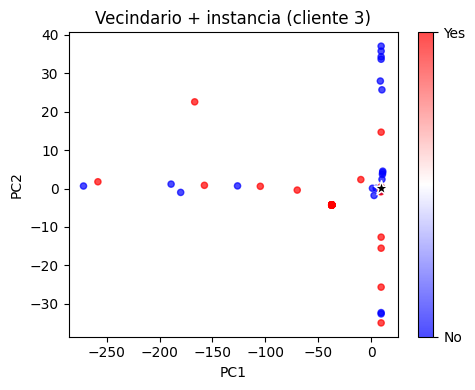

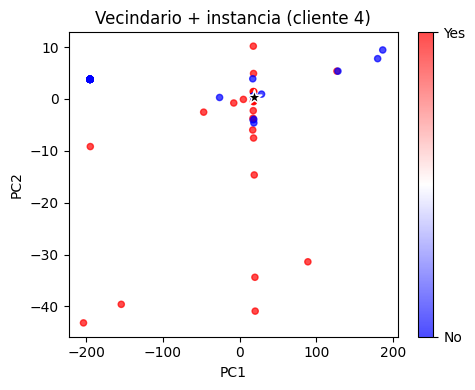

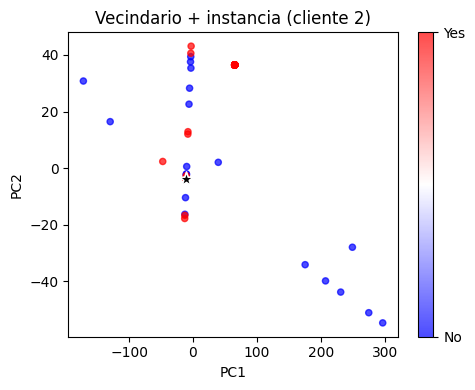

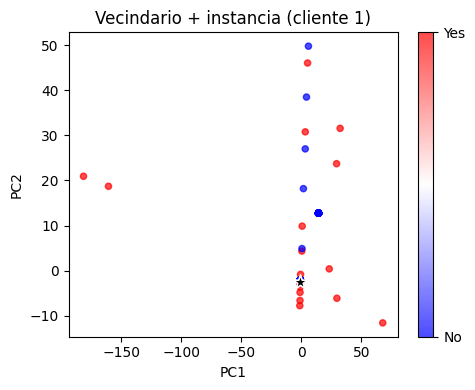

In [13]:
from flwr.simulation import run_simulation
import logging
import warnings
import ray

warnings.filterwarnings("ignore", category=DeprecationWarning)


logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger("filelock").setLevel(logging.WARNING)
logging.getLogger("ray").setLevel(logging.WARNING)
logging.getLogger('graphviz').setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.WARNING)  # O ERROR para ocultar aún más
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("fsspec").setLevel(logging.WARNING)
# logging.getLogger("flwr").setLevel(logging.WARNING)




ray.shutdown()  # Apagar cualquier sesión previa de Ray
ray.init(local_mode=True)  # Desactiva multiprocessing, usa un solo proceso principal

backend_config = {"num_cpus": 1}

run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)


### BALANCED METRICS

In [14]:
# ==============================================
# 📊 Promedio global de métricas por cliente (genérico para cualquier clase)
# ==============================================
import re
from pathlib import Path
import pandas as pd

csv_dir = Path("results")
csv_files = sorted(csv_dir.glob("metrics_Balanced_cliente_*.csv"))
dfs = [pd.read_csv(f) for f in csv_files]
df_all = pd.concat(dfs, ignore_index=True)
print(f"Se han cargado {len(csv_files)} clientes ({len(df_all)} filas totales).")

# --- Crear medias por tipo contrafactual (promedio entre clases) ---
cf_groups = {
    "cf_cov_merged":  r"^cf_cov_merged_",
    "cf_cov_lore":    r"^cf_cov_lore_",
    "cf_cov_super":   r"^cf_cov_super_",
    "cf_prec_merged": r"^cf_prec_merged_",
    "cf_prec_lore":   r"^cf_prec_lore_",
    "cf_prec_super":  r"^cf_prec_super_",
    "cf_sup_merged":  r"^cf_sup_merged_",
    "cf_sup_lore":    r"^cf_sup_lore_",
    "cf_sup_super":   r"^cf_sup_super_",
    "cf_comp_merged": r"^cf_comp_merged_",
    "cf_comp_lore":   r"^cf_comp_lore_",
    "cf_comp_super":  r"^cf_comp_super_",
}

for new_col, pattern in cf_groups.items():
    cols = [c for c in df_all.columns if re.match(pattern, c)]
    if cols:
        # Media por fila entre clases (Yes/No/…)
        df_all[new_col] = df_all[cols].mean(axis=1, skipna=True)

# --- Eliminar columnas de clases específicas (Yes, No, etc.) ---
df_all = df_all[[c for c in df_all.columns
                 if not re.match(r"^cf_(cov|prec|sup|comp)_(merged|lore|super)_[^_]+$", c)]]

# --- Medias globales (solo columnas numéricas limpias) ---
numeric_cols = [
    c for c in df_all.select_dtypes(include=["number"]).columns
    if c not in ["round", "client_id"]
]
means = df_all[numeric_cols].mean().to_frame("mean").reset_index()
means.rename(columns={"index": "metric"}, inplace=True)

# Mostrar y guardar
display(means.head(20))
out_path = csv_dir / "metrics_Balanced_global.csv"
means.to_csv(out_path, index=False, encoding="utf-8")
print(f"\n✅ Promedios guardados en: {out_path}")

Se han cargado 4 clientes (4 filas totales).


,metric,mean
0,silhouette,0.366534
1,fidelity_lore,0.978261
2,fidelity_merged,0.734114
3,fidelity_super,0.734950
4,coverage_factual_merged,0.441472
5,precision_factual_merged,0.992481
6,hit_factual_merged,1.000000
7,support_factual_merged,132.000000
8,complexity_factual_merged,3.000000
9,coverage_factual_lore,0.454013



✅ Promedios guardados en: results\metrics_Balanced_global.csv
